<a href="https://colab.research.google.com/github/VAMSIPOLIPARTHI/Child-labour-/blob/main/Mango_Diseases_Classification_%7C_HACKTHON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import needed modules

In [ ]:
!pip install tensorflow==2.9.1

ERROR: Could not find a version that satisfies the requirement tensorflow==2.9.1 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0)
ERROR: No matching distribution found for tensorflow==2.9.1


In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# **Data Preprocessing**

In [ ]:
# Generate data paths with labels
data_dir = '/kaggle/input/mango-leaf-disease-dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
df

,filepaths,labels
0,/kaggle/input/mango-leaf-disease-dataset/Powde...,Powdery Mildew
1,/kaggle/input/mango-leaf-disease-dataset/Powde...,Powdery Mildew
2,/kaggle/input/mango-leaf-disease-dataset/Powde...,Powdery Mildew
3,/kaggle/input/mango-leaf-disease-dataset/Powde...,Powdery Mildew
4,/kaggle/input/mango-leaf-disease-dataset/Powde...,Powdery Mildew
...,...,...
3995,/kaggle/input/mango-leaf-disease-dataset/Die B...,Die Back
3996,/kaggle/input/mango-leaf-disease-dataset/Die B...,Die Back
3997,/kaggle/input/mango-leaf-disease-dataset/Die B...,Die Back
3998,/kaggle/input/mango-leaf-disease-dataset/Die B...,Die Back


### **Split dataframe into train, valid, and test**

In [ ]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

### **Create image data generator**

In [ ]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 3200 validated image filenames belonging to 8 classes.
Found 480 validated image filenames belonging to 8 classes.
Found 320 validated image filenames belonging to 8 classes.


### **Show sample from train data**

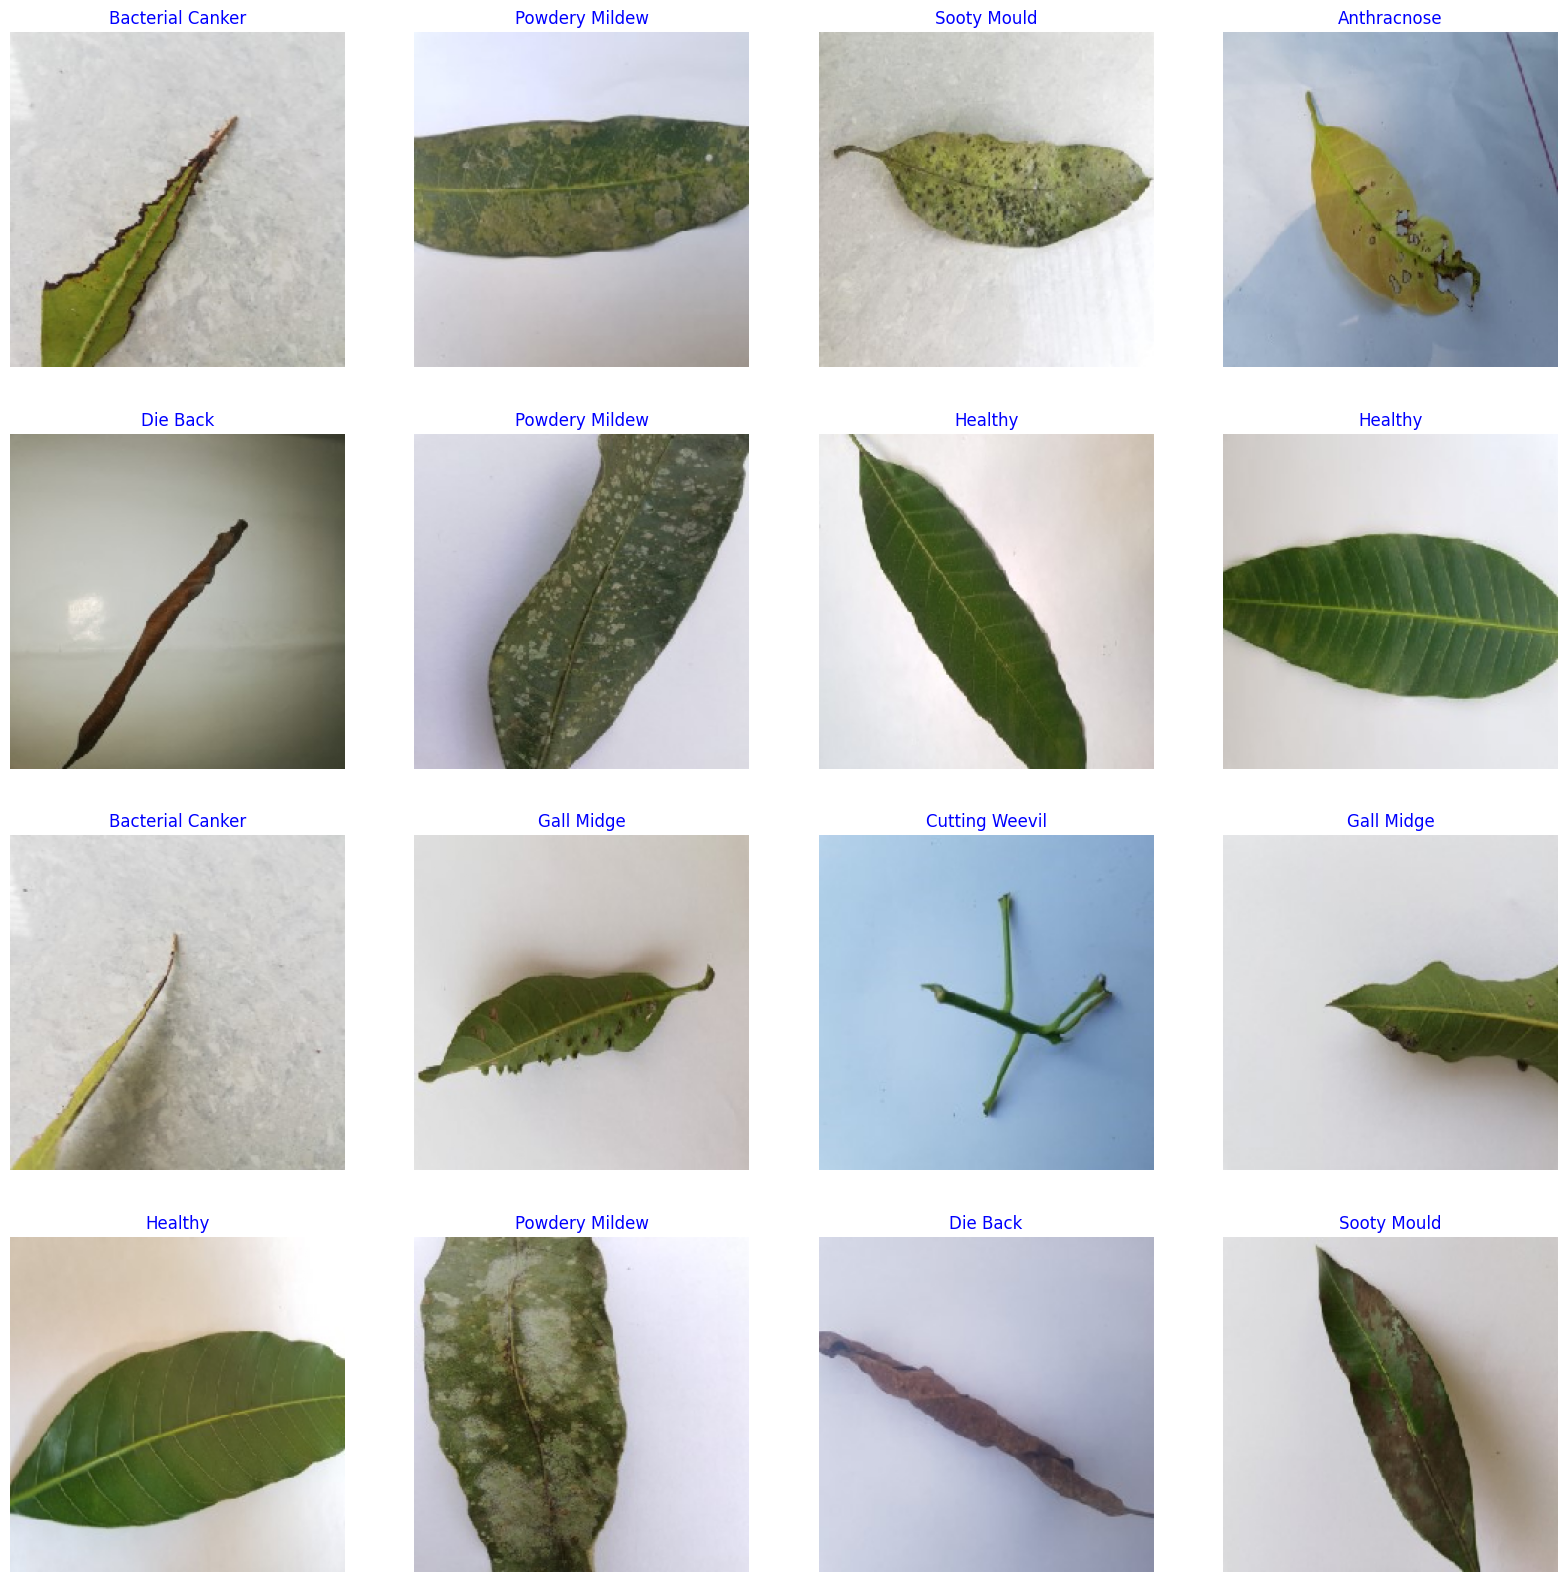

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# **Model Structure**

#### **Generic Model Creation**

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,384,683 (16.73 MB)

 Trainable params: 4,340,100 (16.56 MB)

 Non-trainable params: 44,583 (174.16 KB)

#### **Train model**

In [ ]:

batch_size = 16   # set batch size for training
epochs = 30  # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 1035s 5s/step - accuracy: 0.4758 - loss: 12.6695 - val_accuracy: 0.2958 - val_loss: 8.2519
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 972s 5s/step - accuracy: 0.2165 - loss: 6.9618 - val_accuracy: 0.1875 - val_loss: 6.2618
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 951s 5s/step - accuracy: 0.2098 - loss: 5.7891 - val_accuracy: 0.1917 - val_loss: 5.1237
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 962s 5s/step - accuracy: 0.2182 - loss: 4.8448 - val_accuracy: 0.1854 - val_loss: 4.2876
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 973s 5s/step - accuracy: 0.1996 - loss: 4.1159 - val_accuracy: 0.1458 - val_loss: 3.7166
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 952s 5s/step - accuracy: 0.2082 - loss: 3.5490 - val_accuracy: 0.2125 - val_loss: 3.2010
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 994s 5s/step - accuracy: 0.2186 - loss: 3.1332 - val_accuracy: 0.2125 - val_loss: 2.8353
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 971s 5s/step - accuracy: 0.2111 - loss: 2.8132 - val_ac

#### **Display model performance**

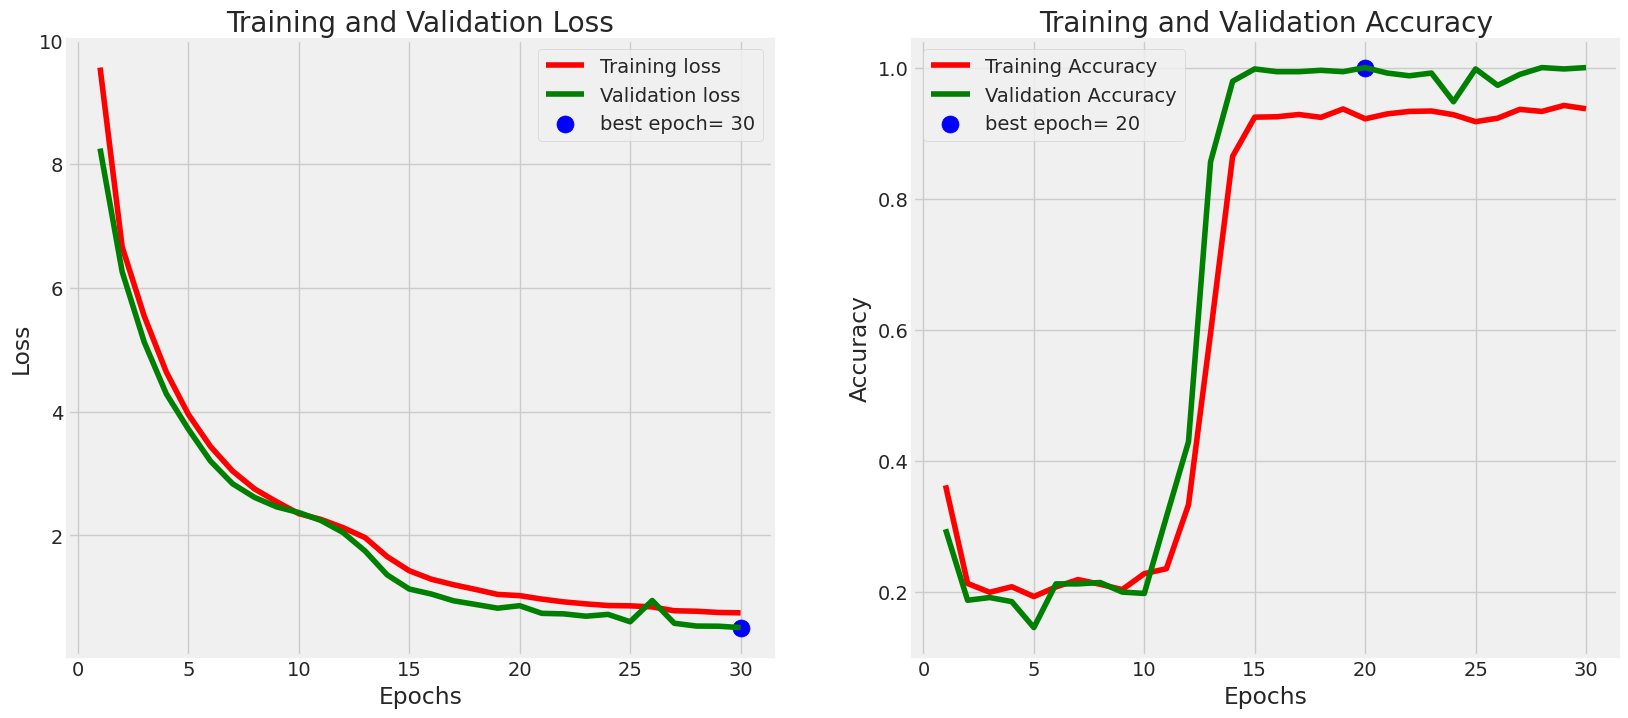

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# **Evaluate model**

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 953ms/step - accuracy: 1.0000 - loss: 0.5070
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 943ms/step - accuracy: 1.0000 - loss: 0.4999
4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step - accuracy: 1.0000 - loss: 2.0945
Train Loss:  0.5123432874679565
Train Accuracy:  1.0
--------------------
Validation Loss:  0.5014167428016663
Validation Accuracy:  1.0
--------------------
Test Loss:  2.087023973464966
Test Accuracy:  1.0


# **Get Predictions**

In [ ]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 29s 6s/step


#### **Confusion Matrics and Classification Report**

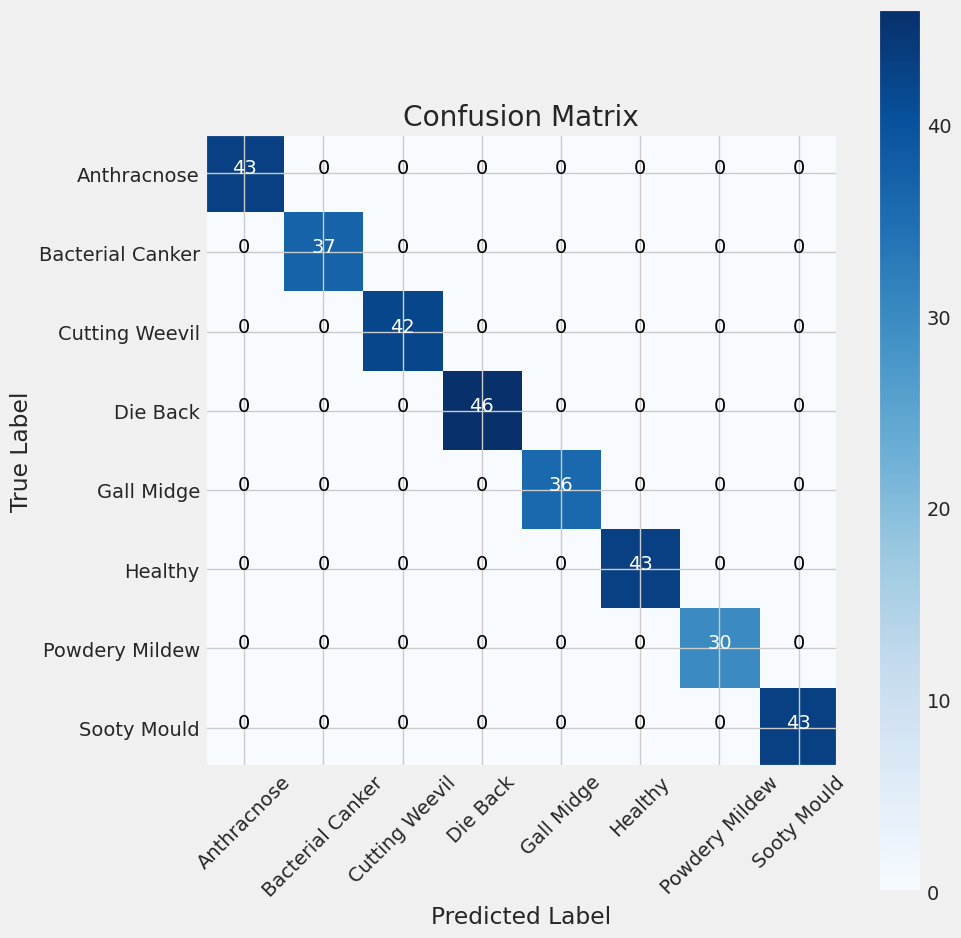

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                  precision    recall  f1-score   support

     Anthracnose       1.00      1.00      1.00        43
Bacterial Canker       1.00      1.00      1.00        37
  Cutting Weevil       1.00      1.00      1.00        42
        Die Back       1.00      1.00      1.00        46
      Gall Midge       1.00      1.00      1.00        36
         Healthy       1.00      1.00      1.00        43
  Powdery Mildew       1.00      1.00      1.00        30
     Sooty Mould       1.00      1.00      1.00        43

        accuracy                           1.00       320
       macro avg       1.00      1.00      1.00       320
    weighted avg       1.00      1.00      1.00       320



#### **Save model**

In [ ]:
model_name = model.layers[0].name
subject = 'Mango_Diseases'  # replace space with underscore
acc = test_score[1] * 100
save_path = ''

# Save model
save_id = f'{model_name}-{subject}-{"%.2f" % round(acc, 2)}.h5'
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = f'{model_name}-{subject}-weights.weights.h5'  # make sure .weights.h5 at the end
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')


model was saved as efficientnetb0-Mango_Diseases-100.00.h5
weights were saved as efficientnetb0-Mango_Diseases-weights.weights.h5


#### **Generate CSV files containing classes indicies & image size**

In [ ]:
model_name = model.layers[0].name
subject = 'Mango_Diseases'  # Replace spaces with underscores for safety
acc = test_score[1] * 100
save_path = ''

# Create filenames
model_save_id_keras = f'{model_name}-{subject}-{"%.2f" % round(acc, 2)}.keras'
model_save_loc_keras = os.path.join(save_path, model_save_id_keras)

weight_save_id = f'{model_name}-{subject}-weights.weights.h5'
weights_save_loc = os.path.join(save_path, weight_save_id)

# Save full model in Keras format (recommended)
model.save(model_save_loc_keras)
print(f'Model was saved as {model_save_loc_keras}')

# Save weights only (optional)
model.save_weights(weights_save_loc)
print(f'Weights were saved as {weights_save_loc}')


Model was saved as efficientnetb0-Mango_Diseases-100.00.keras
Weights were saved as efficientnetb0-Mango_Diseases-weights.weights.h5


In [ ]:
class_dict = train_gen.class_indices
img_size = train_gen.image_shape
height = []
width = []
for _ in range(len(class_dict)):
    height.append(img_size[0])
    width.append(img_size[1])

Index_series = pd.Series(list(class_dict.values()), name= 'class_index')
Class_series = pd.Series(list(class_dict.keys()), name= 'class')
Height_series = pd.Series(height, name= 'height')
Width_series = pd.Series(width, name= 'width')
class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis= 1)
csv_name = f'{subject}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index= False)
print(f'class csv file was saved as {csv_save_loc}')

class csv file was saved as Mango_Diseases-class_dict.csv


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 219 variables whereas the saved optimizer has 436 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


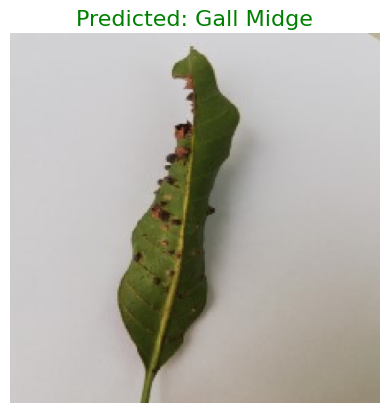

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

# Load the full model
model = load_model('/content/drive/MyDrive/efficientnetb0-Mango_Diseases-100.00.keras')

# Define class names for 8 classes
class_names = {
    0: 'Anthracnose',
    1: 'Bacterial Canker',
    2: 'Cutting Weevil',
    3: 'Die Back',
    4: 'Gall Midge',
    5: 'Healthy',
    6: 'Powdery Mildew',
    7: 'Sooty Mould'
}

# Load and preprocess the test image
img_path = '/content/drive/MyDrive/extracted_data/dataset1/Gall Midge/IMG_20211106_161101 (Custom).jpg'  # Your test image path
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Predict
pred = model.predict(img_array)
predicted_class = np.argmax(pred, axis=1)[0]
predicted_disease = class_names.get(predicted_class, "Unknown")

# Display the image with the predicted label
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted: {predicted_disease}', fontsize=16, color='green')
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
